#imports and reading in data

In [70]:
import pandas as pd
import numpy as np

In [71]:
#script for reading parquet files into pandas dataframes

import logging
from pathlib import Path

#import pandas as pd

logger = logging.getLogger(__name__)


def load_rms_data(rms_parquet_fname: Path) -> pd.DataFrame:
    """
    Loads RMS data from parquet format into a dataframe.

    :param rms_parquet_fname: path to *.rms.parquet, where data is stored in a dataframe
    :return: dataframe sorted by timestamp index, where each column name is the parameter's source
        name.
    """
    df = pd.read_parquet(rms_parquet_fname)

    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df.index = df["Timestamp"]
    df.columns = df.columns.str.replace("_", ".")

    logger.info("%s - %s, tz = %s", df.index.min(), df.index.max(), df.index.tz)

    return df

In [72]:
#importing parquet
from google.colab import files
file = files.upload() 

Saving 2-1-0-150201-95-3926.rms.parquet to 2-1-0-150201-95-3926.rms (1).parquet
Saving 2-1-0-150201-95-3908.rms.parquet to 2-1-0-150201-95-3908.rms (1).parquet
Saving 2-1-0-150201-95-3907.rms.parquet to 2-1-0-150201-95-3907.rms (1).parquet
Saving 2-1-0-150201-95-3898.rms.parquet to 2-1-0-150201-95-3898.rms (1).parquet
Saving 2-1-0-150201-95-3884.rms.parquet to 2-1-0-150201-95-3884.rms (1).parquet
Saving 2-1-0-150201-95-3863.rms.parquet to 2-1-0-150201-95-3863.rms (1).parquet
Saving 2-1-0-150201-95-3826.rms.parquet to 2-1-0-150201-95-3826.rms (1).parquet
Saving 2-1-0-150201-95-3805.rms.parquet to 2-1-0-150201-95-3805.rms (1).parquet
Saving 2-1-0-150201-95-3791.rms.parquet to 2-1-0-150201-95-3791.rms (1).parquet
Saving 2-1-0-150201-95-3733.rms.parquet to 2-1-0-150201-95-3733.rms (1).parquet
Saving 2-1-0-150201-95-3731.rms.parquet to 2-1-0-150201-95-3731.rms (1).parquet
Saving 2-1-0-150201-95-3728.rms.parquet to 2-1-0-150201-95-3728.rms (1).parquet
Saving 2-1-0-150201-95-3718.rms.parquet 

In [73]:
df = pd.DataFrame()
for key in list(file.keys()):
  df = df.append(other=load_rms_data(key))

In [74]:
df.shape

(201404, 145)

In [75]:
df.duplicated().sum()

3789

In [76]:
#deleting duplicate rows
df = df[~df.index.duplicated(keep='first')]

In [77]:
df.shape

(197615, 145)

In [78]:
df.head()

,Timestamp,Dmm.Op.1,Dmm.Op.2,Dmm.Op.2BSand,Dmm.Op.3A,Dmm.Op.3BAny,Dmm.Op.3B,Dmm.Op.3B2,Dmm.Op.3B3,Dmm.Op.3B4,Dmm.Op.4A,Dmm.Op.4BAny,Dmm.Op.4BAmc,Dmm.Op.5,Dmm.Op.6,Cse.St.1,Cse.St.2,Cse.St.3,Cse.St.4,Cse.St.5,Cse.St.6,Amc.St.2,Amc.St.3,Amc.St.4,Dmm.Hy.Prefill,Dmm.Hy.Servo.Enable,Dmm.Motor.On,Dmm.Pboost.High,Dmm.Pn.Dome.Close.Fb,Dmm.Pn.Dome.Close.Set,Dmm.Pn.Dome.Open.Fb,Dmm.Pn.Dome.Open.Set,Dmm.Pn.Dome.Seal,Dmm.Pn.Exhaust1.Close,Dmm.Pn.Exhaust2.Close,Dmm.Pn.Shotvalve1,Dmm.Pp.Sq.Br.Enable,Dmm.Pp.Sq.Enable,Dmm.Pp.Strip.On,Dmm.Sp.Prox.45,...,Dmm.Pp.Pres.B,Dmm.Pp.Pres.Fb,Dmm.Pp.Pres.Set,Dmm.Pp.Servo.Fb,Dmm.Pp.Servo.Set,Dmm.Pp.Sq.Br.Set,Dmm.Pp.Tilt.Fb,Dmm.Pp.Tilt.Set,Dmm.Pp.Vel.Fb,Dmm.Pp.Vel.Set,Dmm.Sand.Level.Fb,Dmm.Sand.Level.Set,Dmm.Sp.Force.Fb,Dmm.Sp.Pos.Fb,Dmm.Sp.Pres.A,Dmm.Sp.Pres.B,Dmm.Sp.Servo.Fb,Dmm.Sp.Servo.Set,Dmm.Sp.Sq.Br.Set,Dmm.Sp.Tilt.Fb,Dmm.Sp.Tilt.Set,Dmm.Sp.Vel.Fb,Dmm.Sp.Vel.Set,Dmm.Spray.Lev.Fb,Amc.Acc.Fb,Amc.Acc.Set,Amc.Clamp.Pres.Fb,Amc.Friction.Fb,Amc.Hy.Pres.Pa.Fb,Amc.Hy.Pres.Pb.Fb,Amc.Hy.Pres.Ps.Fb,Amc.HyForce.Tot.Fb,Amc.HyForce.Xmc.Fb,Amc.Mass.Fb,Amc.Pos.Fb,Amc.Vel.Fb,Amc.Vel.Lim.Set,Amc.Vel.Set,Amc.Vel.Valve.Fb,Amc.Vel.Valve.Set
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-30 22:29:00.786105800+00:00,2021-06-30 22:29:00.786105800+00:00,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,13.723171,1.260127,0.555321,0.184462,0.117271,-1.0,77.906761,74.974998,-1.605545,74.974998,84.389503,75.0,-23.260040,1549.380005,14.084526,14.145737,-0.073062,-0.081534,-1.0,-2.614526,-0.576172,-0.012112,-0.576172,100.0,12.935532,0.0,4.624154,30727.65625,46.063038,138.378891,194.643738,-5092.548828,-17888.412109,79981.921875,363.439209,-0.025004,0.0,0.0,0.019893,0.0
2021-06-30 22:29:00.795005800+00:00,2021-06-30 22:29:00.795005800+00:00,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,13.764383,0.643807,-1.000000,0.047743,4.336222,-1.0,74.405540,-34.000000,-1.383499,-34.000000,84.685844,75.0,-35.090103,1549.385010,14.035075,14.127418,0.007234,0.053617,-1.0,0.757423,-0.583008,0.010636,-0.583008,100.0,0.000000,0.0,4.627073,30727.65625,45.650238,137.233246,194.412903,-17763.271484,-17763.271484,79981.921875,363.445068,0.493749,0.0,0.0,0.018084,0.0
2021-06-30 22:29:00.806505800+00:00,2021-06-30 22:29:00.806505800+00:00,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,14.502228,-0.902054,-1.000000,3.512732,0.098873,-1.0,-37.528175,-40.000000,-1.037105,-40.000000,84.894844,75.0,-9.471951,1549.383057,14.402468,14.427394,0.010127,-0.083749,-1.0,-2.674767,-0.581055,0.001162,-0.581055,100.0,0.000000,0.0,4.627809,30727.65625,45.202812,135.884491,194.044907,-17587.820312,-17587.820312,79981.921875,363.461731,0.936719,0.0,0.0,0.024957,0.0
2021-06-30 22:29:00.815105800+00:00,2021-06-30 22:29:00.815105800+00:00,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,17.017971,-0.876736,-1.000000,0.271990,-1.570268,-1.0,-83.256691,-44.000000,-0.886441,-44.000000,85.113091,75.0,10.980968,1549.383057,14.696095,14.667198,-0.035446,-0.341471,-1.0,-9.117822,-0.581055,0.000941,-0.581055,100.0,0.000000,0.0,4.629623,30727.65625,44.813526,134.916489,193.876617,-17511.679688,-17511.679688,79981.921875,363.479187,1.484180,0.0,0.0,0.020979,0.0
2021-06-30 22:29:00.826505800+00:00,2021-06-30 22:29:00.826505800+00:00,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,23.253061,-0.923032,-1.000000,-0.632234,0.197555,-1.0,-45.061134,-50.000000,-1.567328,-50.000000,85.32587

#cleaning data

In [79]:
#checking for null values
df_null_counts = df.isna().sum()
print(df_null_counts[df_null_counts > 0])

Dmm.Op.2            197615
Dmm.Op.3BAny        197615
Dmm.Op.3B           197615
Dmm.Op.4BAny        197615
Vision.TriggerPP    197615
dtype: int64


In [80]:
#removing null-value columns
df.drop(columns={'Timestamp','Dmm.Op.2','Dmm.Op.3BAny','Dmm.Op.3B','Dmm.Op.4BAny','Vision.TriggerPP'}, inplace=True)
df.head()

,Dmm.Op.1,Dmm.Op.2BSand,Dmm.Op.3A,Dmm.Op.3B2,Dmm.Op.3B3,Dmm.Op.3B4,Dmm.Op.4A,Dmm.Op.4BAmc,Dmm.Op.5,Dmm.Op.6,Cse.St.1,Cse.St.2,Cse.St.3,Cse.St.4,Cse.St.5,Cse.St.6,Amc.St.2,Amc.St.3,Amc.St.4,Dmm.Hy.Prefill,Dmm.Hy.Servo.Enable,Dmm.Motor.On,Dmm.Pboost.High,Dmm.Pn.Dome.Close.Fb,Dmm.Pn.Dome.Close.Set,Dmm.Pn.Dome.Open.Fb,Dmm.Pn.Dome.Open.Set,Dmm.Pn.Dome.Seal,Dmm.Pn.Exhaust1.Close,Dmm.Pn.Exhaust2.Close,Dmm.Pn.Shotvalve1,Dmm.Pp.Sq.Br.Enable,Dmm.Pp.Sq.Enable,Dmm.Pp.Strip.On,Dmm.Sp.Prox.45,Dmm.Sp.Prox.90,Dmm.Sp.Sealing,Dmm.Sp.Sq.Br.Enable,Dmm.Sp.Sq.Enable,Dmm.Sp.Strip.On,...,Dmm.Pp.Pres.B,Dmm.Pp.Pres.Fb,Dmm.Pp.Pres.Set,Dmm.Pp.Servo.Fb,Dmm.Pp.Servo.Set,Dmm.Pp.Sq.Br.Set,Dmm.Pp.Tilt.Fb,Dmm.Pp.Tilt.Set,Dmm.Pp.Vel.Fb,Dmm.Pp.Vel.Set,Dmm.Sand.Level.Fb,Dmm.Sand.Level.Set,Dmm.Sp.Force.Fb,Dmm.Sp.Pos.Fb,Dmm.Sp.Pres.A,Dmm.Sp.Pres.B,Dmm.Sp.Servo.Fb,Dmm.Sp.Servo.Set,Dmm.Sp.Sq.Br.Set,Dmm.Sp.Tilt.Fb,Dmm.Sp.Tilt.Set,Dmm.Sp.Vel.Fb,Dmm.Sp.Vel.Set,Dmm.Spray.Lev.Fb,Amc.Acc.Fb,Amc.Acc.Set,Amc.Clamp.Pres.Fb,Amc.Friction.Fb,Amc.Hy.Pres.Pa.Fb,Amc.Hy.Pres.Pb.Fb,Amc.Hy.Pres.Ps.Fb,Amc.HyForce.Tot.Fb,Amc.HyForce.Xmc.Fb,Amc.Mass.Fb,Amc.Pos.Fb,Amc.Vel.Fb,Amc.Vel.Lim.Set,Amc.Vel.Set,Amc.Vel.Valve.Fb,Amc.Vel.Valve.Set
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-30 22:29:00.786105800+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,13.723171,1.260127,0.555321,0.184462,0.117271,-1.0,77.906761,74.974998,-1.605545,74.974998,84.389503,75.0,-23.260040,1549.380005,14.084526,14.145737,-0.073062,-0.081534,-1.0,-2.614526,-0.576172,-0.012112,-0.576172,100.0,12.935532,0.0,4.624154,30727.65625,46.063038,138.378891,194.643738,-5092.548828,-17888.412109,79981.921875,363.439209,-0.025004,0.0,0.0,0.019893,0.0
2021-06-30 22:29:00.795005800+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,13.764383,0.643807,-1.000000,0.047743,4.336222,-1.0,74.405540,-34.000000,-1.383499,-34.000000,84.685844,75.0,-35.090103,1549.385010,14.035075,14.127418,0.007234,0.053617,-1.0,0.757423,-0.583008,0.010636,-0.583008,100.0,0.000000,0.0,4.627073,30727.65625,45.650238,137.233246,194.412903,-17763.271484,-17763.271484,79981.921875,363.445068,0.493749,0.0,0.0,0.018084,0.0
2021-06-30 22:29:00.806505800+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,14.502228,-0.902054,-1.000000,3.512732,0.098873,-1.0,-37.528175,-40.000000,-1.037105,-40.000000,84.894844,75.0,-9.471951,1549.383057,14.402468,14.427394,0.010127,-0.083749,-1.0,-2.674767,-0.581055,0.001162,-0.581055,100.0,0.000000,0.0,4.627809,30727.65625,45.202812,135.884491,194.044907,-17587.820312,-17587.820312,79981.921875,363.461731,0.936719,0.0,0.0,0.024957,0.0
2021-06-30 22:29:00.815105800+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,17.017971,-0.876736,-1.000000,0.271990,-1.570268,-1.0,-83.256691,-44.000000,-0.886441,-44.000000,85.113091,75.0,10.980968,1549.383057,14.696095,14.667198,-0.035446,-0.341471,-1.0,-9.117822,-0.581055,0.000941,-0.581055,100.0,0.000000,0.0,4.629623,30727.65625,44.813526,134.916489,193.876617,-17511.679688,-17511.679688,79981.921875,363.479187,1.484180,0.0,0.0,0.020979,0.0
2021-06-30 22:29:00.826505800+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,23.253061,-0.923032,-1.000000,-0.632234,0.197555,-1.0,-45.061134,-50.000000,-1.567328,-50.000000,85.325874,75.0,139.875519,1549.386963,15.792124,15.424030,-0.099827,0.039247,-1.0,0.396217,-0.584961,0.016861,-0.584961,100.0,0.000000,0.0,4

In [81]:
df.shape

(197615, 139)

In [82]:
#plotting some data
from matplotlib import pyplot

def plot_some(df):
  values = df.values
  # specify columns to plot
  groups = list(range(df.columns.get_loc("Amc.Clamp.Pres.Fb"), df.columns.get_loc("Amc.HyForce.Xmc.Fb")))
  i = 1
  # plot each column
  pyplot.figure()
  for group in groups:
	  pyplot.subplot(len(groups), 1, i)
	  pyplot.plot(values[:, group])
	  pyplot.title(df.columns[group], y=0.5, loc='right')
	  i += 1
  pyplot.show()

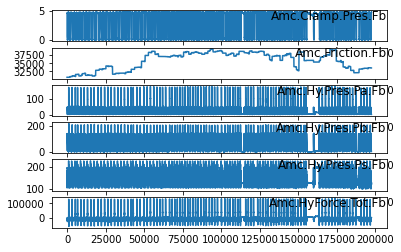

In [83]:
plot_some(df)

#Training LSTM Autoencoder
from https://towardsdatascience.com/using-lstm-autoencoders-on-multidimensional-time-series-data-f5a7a51b29a1

In [84]:
#generating normalized train/test datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle

def fit_scaler(data, scaler_type=StandardScaler):
  scaler = scaler_type()
  scaler.fit(data)
  return scaler

def generate_datasets_for_training(data, window_size, scaler):
  _l = len(data) 
  #normalizing values
  data = scaler.transform(data)
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(data[i:i+window_size])
    Ys.append(data[i:i+window_size])
  X_train, X_test, Y_train, Y_test = [np.array(x) for x in train_test_split(Xs, Ys, train_size = 0.7, shuffle=True)]
  assert X_train.shape[2] == X_test.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
  return  (X_train.shape[2], X_train, X_test, Y_train, Y_test)

In [85]:
#prep
epochs = 50
batch_size = 72 #originally 32
window_size = 4
from keras import metrics
import keras
import tensorflow as tf
import os

#training can stop early at some minimum error threshold to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

model_scaler = fit_scaler(df)
feats, X, XX, Y, YY = generate_datasets_for_training(data=df, window_size=window_size, scaler=model_scaler)

In [86]:
#defining and training the model

model = keras.Sequential()

#encoder layers
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_size, feats), return_sequences=True, name='encoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))

#repeat vector: formats encoded vector so it's readable to the decoder
model.add(keras.layers.RepeatVector(window_size, name='encoder_decoder_bridge'))

#decoder
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))

#dense layer produces sequence similar to input
model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))

model.compile(loss="mse",optimizer='adam')
model.build()
print(model.summary())

#model.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stop])
history = model.fit(x=X, y=Y, validation_data=(XX, YY), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stop])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (LSTM)             (None, 4, 64)             52224     
_________________________________________________________________
encoder_2 (LSTM)             (None, 4, 32)             12416     
_________________________________________________________________
encoder_3 (LSTM)             (None, 16)                3136      
_________________________________________________________________
encoder_decoder_bridge (Repe (None, 4, 16)             0         
_________________________________________________________________
decoder_1 (LSTM)             (None, 4, 16)             2112      
_________________________________________________________________
decoder_2 (LSTM)             (None, 4, 32)             6272      
_________________________________________________________________
decoder_3 (LSTM)             (None, 4, 64)            

In [87]:
history_df = pd.DataFrame(history.history)
print(history_df)

        loss  val_loss
0   0.203562  0.112791
1   0.095303  0.083959
2   0.077743  0.073779
3   0.069796  0.066862
4   0.064577  0.063223
5   0.060793  0.059366
6   0.057326  0.055871
7   0.053924  0.053080
8   0.051195  0.050129
9   0.048894  0.048045
10  0.047085  0.047206
11  0.045566  0.045299
12  0.044355  0.044399


#Predicting using test data

In [20]:
#test data
test_data = files.upload() 

Saving 2-1-0-150201-14-7773.rms.parquet to 2-1-0-150201-14-7773.rms.parquet
Saving 2-1-0-150201-14-7752.rms.parquet to 2-1-0-150201-14-7752.rms.parquet
Saving 2-1-0-150201-14-7714.rms.parquet to 2-1-0-150201-14-7714.rms.parquet
Saving 2-1-0-150201-14-7713.rms.parquet to 2-1-0-150201-14-7713.rms.parquet
Saving 2-1-0-150201-14-7695.rms.parquet to 2-1-0-150201-14-7695.rms.parquet
Saving 2-1-0-150201-14-7672.rms.parquet to 2-1-0-150201-14-7672.rms.parquet
Saving 2-1-0-150201-14-7667.rms.parquet to 2-1-0-150201-14-7667.rms.parquet
Saving 2-1-0-150201-14-7650.rms.parquet to 2-1-0-150201-14-7650.rms.parquet
Saving 2-1-0-150201-14-7648.rms.parquet to 2-1-0-150201-14-7648.rms.parquet
Saving 2-1-0-150201-14-7611.rms.parquet to 2-1-0-150201-14-7611.rms.parquet
Saving 2-1-0-150201-14-7610.rms.parquet to 2-1-0-150201-14-7610.rms.parquet
Saving 2-1-0-150201-14-7577.rms.parquet to 2-1-0-150201-14-7577.rms.parquet
Saving 2-1-0-150201-14-7527.rms.parquet to 2-1-0-150201-14-7527.rms.parquet
Saving 2-1-0

In [88]:
test_df = pd.DataFrame()
for key in list(test_data.keys()):
  test_df = test_df.append(other=load_rms_data(key))

In [89]:
test_df.shape

(43811, 145)

In [90]:
test_df.duplicated().sum()

2188

In [91]:
#deleting duplicate rows
test_df = test_df[~test_df.index.duplicated(keep='first')]

In [92]:
test_df.shape

(41623, 145)

In [93]:
#checking for null values
test_df_null_counts = test_df.isna().sum()
print(test_df_null_counts[test_df_null_counts > 0])

Dmm.Op.2            41623
Dmm.Op.3BAny        41623
Dmm.Op.3B           41623
Dmm.Op.4BAny        41623
Vision.TriggerPP    41623
dtype: int64


In [94]:
#removing null-value columns
test_df.drop(columns={'Timestamp','Dmm.Op.2','Dmm.Op.3BAny','Dmm.Op.3B','Dmm.Op.4BAny','Vision.TriggerPP'}, inplace=True)

In [95]:
test_df.shape

(41623, 139)

In [96]:
def format_dataset_for_testing(data, window_size, scaler):
  _l = len(data)
  #normalizing values
  data = scaler.transform(data)
  Xs = []
  for i in range(0, (_l - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(data[i:i+window_size])
  return np.array(Xs)

In [97]:
#format test data using scaler from training
X_test = format_dataset_for_testing(data=test_df, window_size=window_size, scaler=model_scaler)

In [98]:
X_test.shape

(41619, 4, 139)

In [99]:
pred_X_raw = model.predict(X_test, batch_size=batch_size)

In [100]:
score = model.evaluate(pred_X_raw, X_test, batch_size=batch_size, verbose=1)

579/579 [==============================] - 3s 5ms/step - loss: 2.4605


In [101]:
pred_X_raw.shape

(41619, 4, 139)

In [102]:
pred_X_raw

array([[[-2.63128549e-01, -6.19145215e-01, -3.91527101e-05, ...,
          4.83230352e-01,  4.47505951e-01,  3.89412373e-01],
        [-2.12672040e-01, -4.00192142e-01, -2.89855143e-05, ...,
          1.28293484e-02,  1.88930854e-01,  1.04738317e-01],
        [-3.33965302e-01, -1.57871932e-01, -2.09459849e-05, ...,
         -5.50447285e-01, -3.55934232e-01, -5.01982331e-01],
        [-3.03326547e-01, -1.70883715e-01, -4.38703682e-06, ...,
         -7.30151594e-01, -6.73984289e-01, -8.55750203e-01]],

       [[-3.94540608e-01, -3.94063532e-01, -1.96402652e-05, ...,
         -7.70398974e-03,  7.58081898e-02, -3.44886556e-02],
        [-4.13331270e-01, -1.11197621e-01, -1.43374473e-05, ...,
         -4.85262513e-01, -4.32980388e-01, -6.42592490e-01],
        [-3.10993612e-01, -2.99467951e-01, -2.62193134e-06, ...,
         -3.66906047e-01, -2.35008582e-01, -3.81722987e-01],
        [-1.06130734e-01, -4.34529006e-01, -1.77697329e-05, ...,
         -5.04119754e-01, -7.40423873e-02, -1.34102

In [103]:
def unroll_pred(pred_X):
    predictions = list()
    pred_length = pred_X.shape[1]
    num_errors = pred_X.shape[1] + (pred_X.shape[0] - 1)

    for i in range(num_errors):
            intermediate = []

            for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
                intermediate.append(pred_X[i - j, j])

            if intermediate:
                median_vector = []
                for k in range(pred_X.shape[2]):
                    candidate_vector = [i_vector[k] for i_vector in intermediate]
                    median_vector.append(np.median(candidate_vector))
                #predictions.append(np.median(np.asarray(intermediate)))
                predictions.append(np.asarray(median_vector))

    return np.asarray(predictions[pred_length-1:])

In [104]:
#unroll predictions
pred_X_unrolled = unroll_pred(pred_X_raw)

In [105]:
#unscale predictions
pred_X = model_scaler.inverse_transform(pred_X_unrolled)

In [106]:
#convert to df
pred_df = pd.DataFrame(pred_X, columns = test_df.columns)

In [107]:
test_df.tail()

,Dmm.Op.1,Dmm.Op.2BSand,Dmm.Op.3A,Dmm.Op.3B2,Dmm.Op.3B3,Dmm.Op.3B4,Dmm.Op.4A,Dmm.Op.4BAmc,Dmm.Op.5,Dmm.Op.6,Cse.St.1,Cse.St.2,Cse.St.3,Cse.St.4,Cse.St.5,Cse.St.6,Amc.St.2,Amc.St.3,Amc.St.4,Dmm.Hy.Prefill,Dmm.Hy.Servo.Enable,Dmm.Motor.On,Dmm.Pboost.High,Dmm.Pn.Dome.Close.Fb,Dmm.Pn.Dome.Close.Set,Dmm.Pn.Dome.Open.Fb,Dmm.Pn.Dome.Open.Set,Dmm.Pn.Dome.Seal,Dmm.Pn.Exhaust1.Close,Dmm.Pn.Exhaust2.Close,Dmm.Pn.Shotvalve1,Dmm.Pp.Sq.Br.Enable,Dmm.Pp.Sq.Enable,Dmm.Pp.Strip.On,Dmm.Sp.Prox.45,Dmm.Sp.Prox.90,Dmm.Sp.Sealing,Dmm.Sp.Sq.Br.Enable,Dmm.Sp.Sq.Enable,Dmm.Sp.Strip.On,...,Dmm.Pp.Pres.B,Dmm.Pp.Pres.Fb,Dmm.Pp.Pres.Set,Dmm.Pp.Servo.Fb,Dmm.Pp.Servo.Set,Dmm.Pp.Sq.Br.Set,Dmm.Pp.Tilt.Fb,Dmm.Pp.Tilt.Set,Dmm.Pp.Vel.Fb,Dmm.Pp.Vel.Set,Dmm.Sand.Level.Fb,Dmm.Sand.Level.Set,Dmm.Sp.Force.Fb,Dmm.Sp.Pos.Fb,Dmm.Sp.Pres.A,Dmm.Sp.Pres.B,Dmm.Sp.Servo.Fb,Dmm.Sp.Servo.Set,Dmm.Sp.Sq.Br.Set,Dmm.Sp.Tilt.Fb,Dmm.Sp.Tilt.Set,Dmm.Sp.Vel.Fb,Dmm.Sp.Vel.Set,Dmm.Spray.Lev.Fb,Amc.Acc.Fb,Amc.Acc.Set,Amc.Clamp.Pres.Fb,Amc.Friction.Fb,Amc.Hy.Pres.Pa.Fb,Amc.Hy.Pres.Pb.Fb,Amc.Hy.Pres.Ps.Fb,Amc.HyForce.Tot.Fb,Amc.HyForce.Xmc.Fb,Amc.Mass.Fb,Amc.Pos.Fb,Amc.Vel.Fb,Amc.Vel.Lim.Set,Amc.Vel.Set,Amc.Vel.Valve.Fb,Amc.Vel.Valve.Set
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-06 16:51:11.250228400+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,14.136833,-0.904948,-1.0,0.090423,0.309184,-1.0,15.009253,7.279663,0.075993,7.279663,52.373936,75.0,-3657.808838,916.906006,14.498764,24.124577,0.032553,0.025177,-1.0,-8.565882,-9.195312,0.096868,-9.195312,100.0,0.0,0.0,5.303671,25956.5,3.463834,4.481842,123.458450,859.839844,859.839844,74489.453125,9.106002,0.0,0.0,0.0,0.019170,0.0
2020-07-06 16:51:11.259128400+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,13.966916,-0.912182,-1.0,0.294416,-0.431256,-1.0,-3.401636,7.379761,0.019898,7.379761,52.376442,75.0,-3631.991211,916.903015,14.434375,23.992247,0.070168,-0.291864,-1.0,-16.489466,-9.192871,0.071749,-9.192871,100.0,0.0,0.0,5.285065,25956.5,3.452041,4.418620,122.930496,874.764954,874.764954,74489.453125,9.107250,0.0,0.0,0.0,0.016275,0.0
2020-07-06 16:51:11.270628400+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,14.033947,-0.887587,-1.0,0.023148,0.468988,-1.0,19.214331,7.489624,-0.109503,7.489624,52.358517,75.0,-3730.826416,916.918030,14.341139,24.159103,-0.109230,-0.085797,-1.0,-11.387110,-9.242188,0.195448,-9.242188,100.0,0.0,0.0,5.283230,25956.5,3.431270,4.461968,123.101273,843.470276,843.470276,74489.453125,9.103157,0.0,0.0,0.0,0.029297,0.0
2020-07-06 16:51:11.279128400+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,14.045022,-0.919415,-1.0,0.412326,0.027338,-1.0,7.963110,7.279663,-0.022474,7.279663,52.367546,75.0,-3729.027832,916.901978,14.406193,24.219423,-0.013021,-0.031395,-1.0,-10.006556,-9.221680,0.096820,-9.221680,100.0,0.0,0.0,5.292439,25956.5,3.412252,4.418172,123.835846,845.891907,845.891907,74489.453125,9.100539,0.0,0.0,0.0,0.026041,0.0
2020-07-06 16:51:11.290628400+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,13.861046,-0.908565,-1.0,-2.324943,-3.476891,-1.0,18.077734,105.000000,-0.108852,105.000000,52.396114,75.0,-3827.981445,916.914001,14.364976,24.438612,-1.381656,-2.607464,-1.0,-10.186609,55.000000,0.104212,55.000000,100.0,0.0,0.0,5.296864,25956.5,3.356219,4.402007,124.977684,811.012817,811.012817,74489.453125,9.099816,0.0,0.0,0.0,0.017723,0.0


In [108]:
pred_df.tail()

,Dmm.Op.1,Dmm.Op.2BSand,Dmm.Op.3A,Dmm.Op.3B2,Dmm.Op.3B3,Dmm.Op.3B4,Dmm.Op.4A,Dmm.Op.4BAmc,Dmm.Op.5,Dmm.Op.6,Cse.St.1,Cse.St.2,Cse.St.3,Cse.St.4,Cse.St.5,Cse.St.6,Amc.St.2,Amc.St.3,Amc.St.4,Dmm.Hy.Prefill,Dmm.Hy.Servo.Enable,Dmm.Motor.On,Dmm.Pboost.High,Dmm.Pn.Dome.Close.Fb,Dmm.Pn.Dome.Close.Set,Dmm.Pn.Dome.Open.Fb,Dmm.Pn.Dome.Open.Set,Dmm.Pn.Dome.Seal,Dmm.Pn.Exhaust1.Close,Dmm.Pn.Exhaust2.Close,Dmm.Pn.Shotvalve1,Dmm.Pp.Sq.Br.Enable,Dmm.Pp.Sq.Enable,Dmm.Pp.Strip.On,Dmm.Sp.Prox.45,Dmm.Sp.Prox.90,Dmm.Sp.Sealing,Dmm.Sp.Sq.Br.Enable,Dmm.Sp.Sq.Enable,Dmm.Sp.Strip.On,...,Dmm.Pp.Pres.B,Dmm.Pp.Pres.Fb,Dmm.Pp.Pres.Set,Dmm.Pp.Servo.Fb,Dmm.Pp.Servo.Set,Dmm.Pp.Sq.Br.Set,Dmm.Pp.Tilt.Fb,Dmm.Pp.Tilt.Set,Dmm.Pp.Vel.Fb,Dmm.Pp.Vel.Set,Dmm.Sand.Level.Fb,Dmm.Sand.Level.Set,Dmm.Sp.Force.Fb,Dmm.Sp.Pos.Fb,Dmm.Sp.Pres.A,Dmm.Sp.Pres.B,Dmm.Sp.Servo.Fb,Dmm.Sp.Servo.Set,Dmm.Sp.Sq.Br.Set,Dmm.Sp.Tilt.Fb,Dmm.Sp.Tilt.Set,Dmm.Sp.Vel.Fb,Dmm.Sp.Vel.Set,Dmm.Spray.Lev.Fb,Amc.Acc.Fb,Amc.Acc.Set,Amc.Clamp.Pres.Fb,Amc.Friction.Fb,Amc.Hy.Pres.Pa.Fb,Amc.Hy.Pres.Pb.Fb,Amc.Hy.Pres.Ps.Fb,Amc.HyForce.Tot.Fb,Amc.HyForce.Xmc.Fb,Amc.Mass.Fb,Amc.Pos.Fb,Amc.Vel.Fb,Amc.Vel.Lim.Set,Amc.Vel.Set,Amc.Vel.Valve.Fb,Amc.Vel.Valve.Set
41614,0.042282,-0.022454,-0.000088,0.000033,0.002357,0.024493,0.034440,0.029152,0.022948,-0.068697,-0.130666,-0.036423,0.003181,0.018653,-0.050967,0.542262,0.029417,-0.005679,0.066776,1.004621,1.000000,1.000010,-0.074564,-0.067559,0.024728,0.856303,0.975244,-0.070695,1.004180,1.086043,0.043320,1.001478,-0.018446,-0.013554,0.838411,0.984510,0.033271,0.999759,-0.060831,-0.000014,...,12.081955,-0.466334,-0.737294,-0.585079,-0.755727,-1.000477,-40.202202,-22.845476,13.447695,43.537445,54.911404,74.999992,-2459.961914,963.037109,3.221482,10.456221,-0.593690,-0.725332,-1.0,11.125765,30.286400,-66.556969,-17.859753,99.999947,40.884998,-2.676833,4.451108,32725.458984,10.864055,15.800888,134.968948,1637.954224,1203.560547,76278.242188,15.606083,-2.865972,-6.501598,-4.320758,-0.129755,-0.163646
41615,0.044460,-0.024202,-0.000088,0.000033,0.004565,0.023885,0.031531,0.028400,0.024008,-0.072525,-0.137732,-0.034665,0.003652,0.018631,-0.047699,0.527966,0.029284,-0.006527,0.068587,1.004258,1.000000,1.000010,-0.077102,-0.068235,0.021187,0.857849,0.978783,-0.073067,1.005929,1.084117,0.045556,1.001520,-0.019960,-0.012986,0.842939,0.983977,0.032705,0.999754,-0.066088,-0.000014,...,12.057682,-0.456276,-0.731460,-0.614306,-0.792334,-1.000490,-48.350147,-30.221704,3.738668,35.069111,54.947056,74.999992,-2314.971680,961.478577,3.203139,9.849831,-0.614181,-0.743367,-1.0,8.577570,28.168762,-71.897110,-20.486240,99.999947,42.118347,1.269821,4.456335,32672.910156,11.052126,15.997787,135.081131,1652.344360,1215.223145,76264.085938,15.440350,-2.821928,-6.474041,-4.182954,-0.134439,-0.169118
41616,0.048153,-0.021682,-0.000098,0.000034,0.019382,0.025349,0.048817,0.026272,0.077512,-0.109794,-0.146756,-0.047808,0.017778,0.008758,-0.044397,0.370778,0.028301,-0.012322,0.078758,0.984148,1.000000,1.000016,-0.059289,-0.066139,0.063409,0.767640,0.936539,-0.053268,1.020363,1.097788,0.048367,1.001921,-0.019007,-0.014926,0.829258,0.976467,0.039114,0.999705,-0.056283,-0.000018,...,12.270177,-0.266208,-0.651896,-0.777001,-0.917239,-1.000424,-39.128254,-12.128956,-37.217266,72.533096,56.156033,74.999992,-1141.242676,975.720581,3.455529,7.760509,-0.791721,-0.955138,-1.0,42.207886,67.287476,-72.158272,2.982849,99.999954,43.892044,8.902806,4.403621,32595.912109,13.791965,22.914072,135.661804,1673.267700,1245.451172,76214.828125,21.777020,-3.354152,-7.831721,-4.668046,-0.169703,-0.205312
41617,0.043314,0.002880,-0.000097,0.000033,0.030271,0.022472,0.059959,0.035587,0.098040,-0.123416,-0.099251,-0.053388,0.028432,0.002500,-0.036448,0.255475,0.037803,-0.007586,0.089869,0.998688,0.999999,1.000018,-0.071461,-0.066363,0.136993,0.758932,0.862958,-0.011695,1.004910,1.141965,0.043016,1.001967,0.010901,-0.020149,0.788785,0.946627,0.054647,0.999698,-0.058146,-0.000019,...,12.929280,-0.243625,-0.632070,-0.789267,-0.

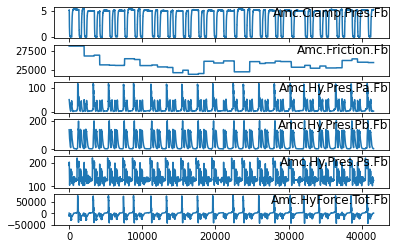

In [109]:
plot_some(test_df)

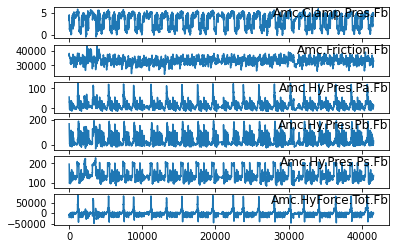

In [110]:
plot_some(pred_df)

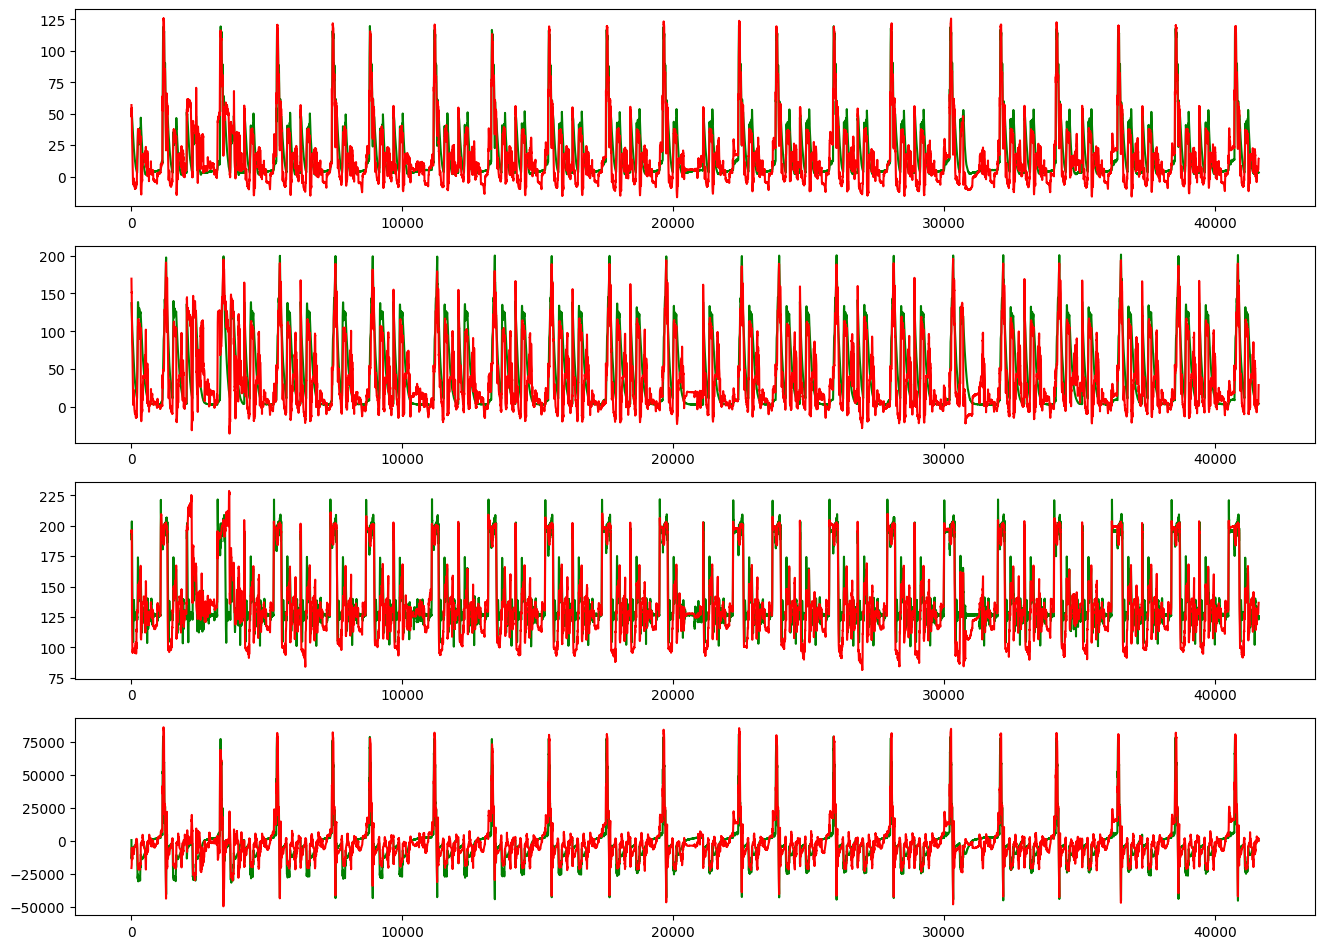

In [111]:
#plotting both

test_values = test_df.values
pred_values = pred_df.values
# specify columns to plot
groups = list(range(test_df.columns.get_loc("Amc.Hy.Pres.Pa.Fb"), test_df.columns.get_loc("Amc.HyForce.Xmc.Fb")))
i = 1
# plot each column
pyplot.figure(figsize=(16, 12), dpi=100)
for group in groups:
  pyplot.subplot(len(groups), 1, i)
  pyplot.plot(test_values[:, group], color='g')
  pyplot.plot(pred_values[:, group], color='r')
  #pyplot.title(df.columns[group], y=0.5, loc='right')
  i += 1
pyplot.show()

#Separating encoder and decoder

In [ ]:
#generating normalized train/test datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def generate_datasets_for_training(data, window_size, scale=True, scaler_type=StandardScaler):
  _l = len(data) 
  #normalizing values
  data = scaler_type().fit_transform(data)
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(data[i:i+window_size])
    Ys.append(data[i:i+window_size])
  X_train, X_test, Y_train, Y_test = [np.array(x) for x in train_test_split(Xs, Ys, train_size = 0.7)]
  assert X_train.shape[2] == X_test.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
  return  (X_train.shape[2], X_train, X_test, Y_train, Y_test)

In [ ]:
#prep
epochs = 50
batch_size = 72 #originally 32
window_size = 4
from keras import metrics
import keras
import tensorflow as tf
import os

#training can stop early at some minimum error threshold to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

feats, X_train, X_test, Y_train, Y_test = generate_datasets_for_training(df, window_size)

In [ ]:
X_train.shape

(138327, 4, 139)

In [ ]:
from keras import layers

#encoder stuff: input (None, 4, feats), output (None, 16)
encoder_input = layers.Input(shape=(window_size, feats), name='encoder_input')
encoder_L1 = layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='encoder_L1')(encoder_input)
encoder_L2 = layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_L2')(encoder_L1)
encoder_L3 = layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_L3')(encoder_L2)

#bridge: input (None, 16), output (None, 4, 16)
#not part of encoder or decoder; will be necessary to connect the two
encoder_decoder_bridge = layers.RepeatVector(window_size, name='encoder_decoder_bridge')(encoder_L3)

#decoder stuff: input (None, 4, 16), output (None, 4, feats)
decoder_input = layers.Input(shape=(window_size, 16), name='decoder_input')
decoder_L1 = layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_L1')(decoder_input)
decoder_L2 = layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_L2')(decoder_L1)
decoder_L3 = layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_L3')(decoder_L2)
decoder_output = layers.TimeDistributed(keras.layers.Dense(feats))(decoder_L3)

In [ ]:
#encoder
encoder = keras.Model(inputs=[encoder_input], outputs=[encoder_L3]) #output must be passed through repeat vector in order to fed to decoder

#decoder
decoder = keras.Model(inputs=[decoder_input], outputs=[decoder_output])